In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pickle5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
------------------------------------------------------------------------


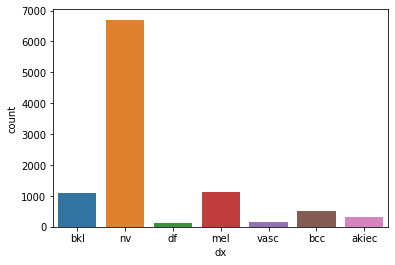

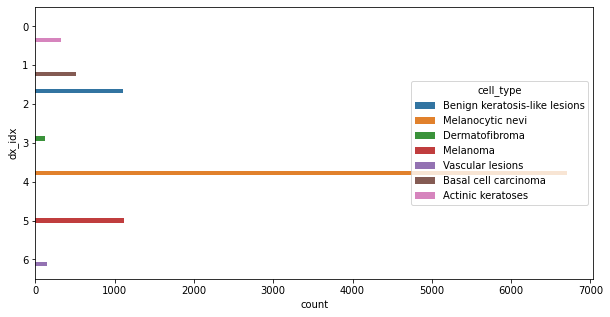

------------------------------------------------------------------------
Toplam resim sayısı = 10015
Melanositik nevüs diğer etiketlere göre çok daha sık olduğu için dengesizdir.
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64
------------------------------------------------------------------------
(128, 128, 3)
Shape one-hot encoding:  (10015, 7)
(8012, 128, 128, 3)
(8012, 7)
(2003, 128, 128, 3)
(2003, 7)
son eğitim örnekleri sayısı = 7210
test örnekleri sayısı = 2003
X_train şekli:(7210, 128, 128, 3)
Y_train şekli:(7210, 7)
X_test şekli: (2003, 128, 128, 3)
Y_test şekli: (2003, 7)
X_val shape(802, 128, 128, 3)
Y_val shape(802, 7)


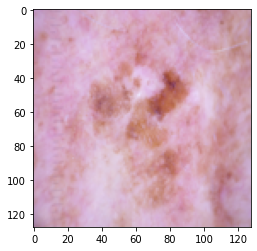

In [ ]:
from PIL import  Image
import matplotlib.pyplot as plt
import pandas as pd # veri işleme - data processing, csv file 
import numpy as np
import seaborn as sns

from keras.models import load_model,Model
from keras.layers import MaxPool2D, Dropout, Dense
from keras.optimizers import Adam

from keras.utils.np_utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint ,EarlyStopping

#from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import layers

import pickle5 as pickle

from sklearn.metrics import classification_report

skin_df = pd.read_csv("/content/drive/MyDrive/cancer_skin/HAM10000_metadata.csv")
skin_df.head()#data hakkında bilgi 10015
skin_df.info()#
print('------------------------------------------------------------------------')
sns.countplot(x = "dx", data = skin_df)#dağılımları nasıl olduğu tablo
plt.show()

lesion_dict = {     
                  'nv': 'Melanocytic nevi',
                  'mel': 'Melanoma',
                  'bkl': 'Benign keratosis-like lesions',
                  'bcc': 'Basal cell carcinoma',
                  'akiec': 'Actinic keratoses',
                  'vasc': 'Vascular lesions',
                  'df': 'Dermatofibroma'
              }

skin_df['cell_type'] = skin_df['dx'].map(lesion_dict.get)
skin_df['dx_idx'] = pd.Categorical(skin_df['cell_type']).codes

fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='dx_idx',data=skin_df, hue="cell_type",ax=ax1)
plt.show()

print('------------------------------------------------------------------------')
print('Toplam resim sayısı =',len(skin_df))
print('Melanositik nevüs diğer etiketlere göre çok daha sık olduğu için dengesizdir.')

sayi =skin_df['cell_type'].value_counts()
print(sayi)
print('------------------------------------------------------------------------')

#% ön işlem veriset
data_folder_name = "/content/drive/MyDrive/cancer_skin/HAM10000_images_part_1/"
ext = ".jpg"
skin_df["path"] = [ data_folder_name + i + ext for i in skin_df["image_id"]] #for döngüsü ile  resim id erişim yolunu elde etti
"""skin_df["image"] = skin_df["path"].map( lambda x: np.asarray(Image.open(x).resize((128,128))))#array olarak yükledi
plt.imshow(skin_df["image"][0])
skin_df["dx_idx"] = pd.Categorical(skin_df["dx"]).codes#sayılara çevirdi - integer 
skin_df.to_pickle("/content/drive/MyDrive/cancer_skin/skin_dff.pkl")#kaydetme - veri depolandı"""

#% yükle pkl
skin_df=pickle.load( open ( "/content/drive/MyDrive/cancer_skin/skin_dff.pkl" ,  "rb" ))
plt.imshow(skin_df["image"][0])
print(skin_df['image'][0].shape)



Y = to_categorical(skin_df["dx_idx"], num_classes = 7)
print("Shape one-hot encoding: ", Y.shape)



X_train, X_test, Y_train, Y_test = train_test_split(skin_df,Y,test_size=0.20)
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


X_train,X_val, Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.10, random_state=42)

X_train  = X_train.reshape(X_train.shape[0],128,128,3)
X_test  = X_test.reshape(X_test.shape[0],128,128,3)
X_val  = X_val.reshape(X_val.shape[0],128,128,3)


print ("son eğitim örnekleri sayısı = " + str(X_train.shape[0]))
print ("test örnekleri sayısı = " + str(X_test.shape[0]))
print ("X_train şekli:" + str(X_train.shape))
print ("Y_train şekli:" + str(Y_train.shape))
print ("X_test şekli: " + str(X_test.shape))
print ("Y_test şekli: " + str(Y_test.shape))

print("X_val shape" + str(X_val.shape))
print("Y_val shape" + str(Y_val.shape))


In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
 
pre_trained_model = InceptionV3(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
 
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
 
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
 
 
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)
model = Model(pre_trained_model.input, x)


optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
 
model.summary()
 
 
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
 
train_datagen.fit(X_train)
 
val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)
 
batch_size = 32
epochs = 10
history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))
 
for layer in pre_trained_model.layers:
    layer.trainable = True
 
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min' ,verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/cancer_skin/checkpoint.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
 
model.summary()
 
 
batch_size = 64
epochs = 40
history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction, early_stopping, checkpoint])
 
 
model.save("/content/drive/MyDrive/cancer_skin/InceptionV3.h5")


input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
activation

In [ ]:
scores=model.evaluate(X_test,Y_test)
print("Test başarı oran:%{:.2f}".format(scores[1]*100))

scores=model.evaluate(X_val,Y_val)
print("Validation başarı oran:%{:.2f}".format(scores[1]*100))

63/63 [==============================] - 8s 22ms/step - loss: 0.5736 - acc: 0.8597
Test başarı oran:%85.97
26/26 [==============================] - 1s 29ms/step - loss: 0.7496 - acc: 0.8379
Validation başarı oran:%83.79


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


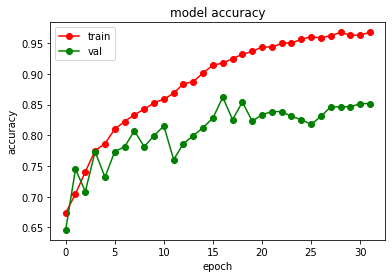

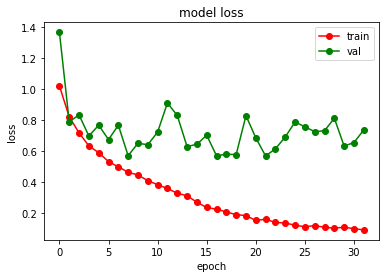

In [ ]:
print(history.history.keys())

plt.plot(history.history['acc'],'ro-')
plt.plot(history.history['val_acc'] , 'go-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/cancer_skin/sonuc/acc_v3.png',dpi=300)
plt.show()

plt.plot(history.history['loss'] ,'ro-')
plt.plot(history.history['val_loss'], 'go-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/cancer_skin/sonuc/loss_v3.png',dpi=300)
plt.show()

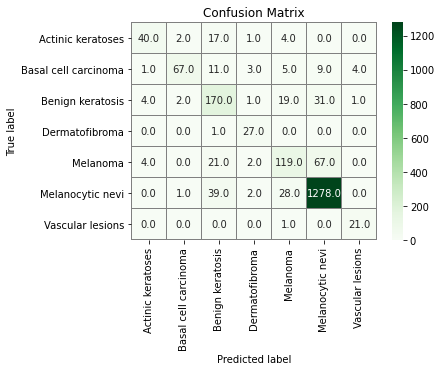

[[  40    2   17    1    4    0    0]
 [   1   67   11    3    5    9    4]
 [   4    2  170    1   19   31    1]
 [   0    0    1   27    0    0    0]
 [   4    0   21    2  119   67    0]
 [   0    1   39    2   28 1278    0]
 [   0    0    0    0    1    0   21]]


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))


cm_df = pd.DataFrame(matrix,
                     index = ['Actinic keratoses','Basal cell carcinoma','Benign keratosis', 'Dermatofibroma','Melanoma','Melanocytic nevi','Vascular lesions'], 
                     columns = ['Actinic keratoses','Basal cell carcinoma','Benign keratosis', 'Dermatofibroma','Melanoma','Melanocytic nevi','Vascular lesions'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",fmt= '.1f')
plt.title('Confusion Matrix'); 
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/content/drive/MyDrive/cancer_skin/sonuc/cm_v3.png',dpi=300)
plt.show()


#  One-hot encoding the classes
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Gerçek etiketin çıkarılması
Y_true_classes = np.argmax(Y_test, axis = 1) 
print(confusion_matrix(Y_true_classes, y_pred_classes))




In [ ]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(Y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Toplam test verileri;', total, '\t doğru-tahmin edilmiş-veri:', accurate, '\t yanlış tahmin edilmiş veri: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

Toplam test verileri; 2003 	 doğru-tahmin edilmiş-veri: 1722 	 yanlış tahmin edilmiş veri:  281
Accuracy: 85.971 %


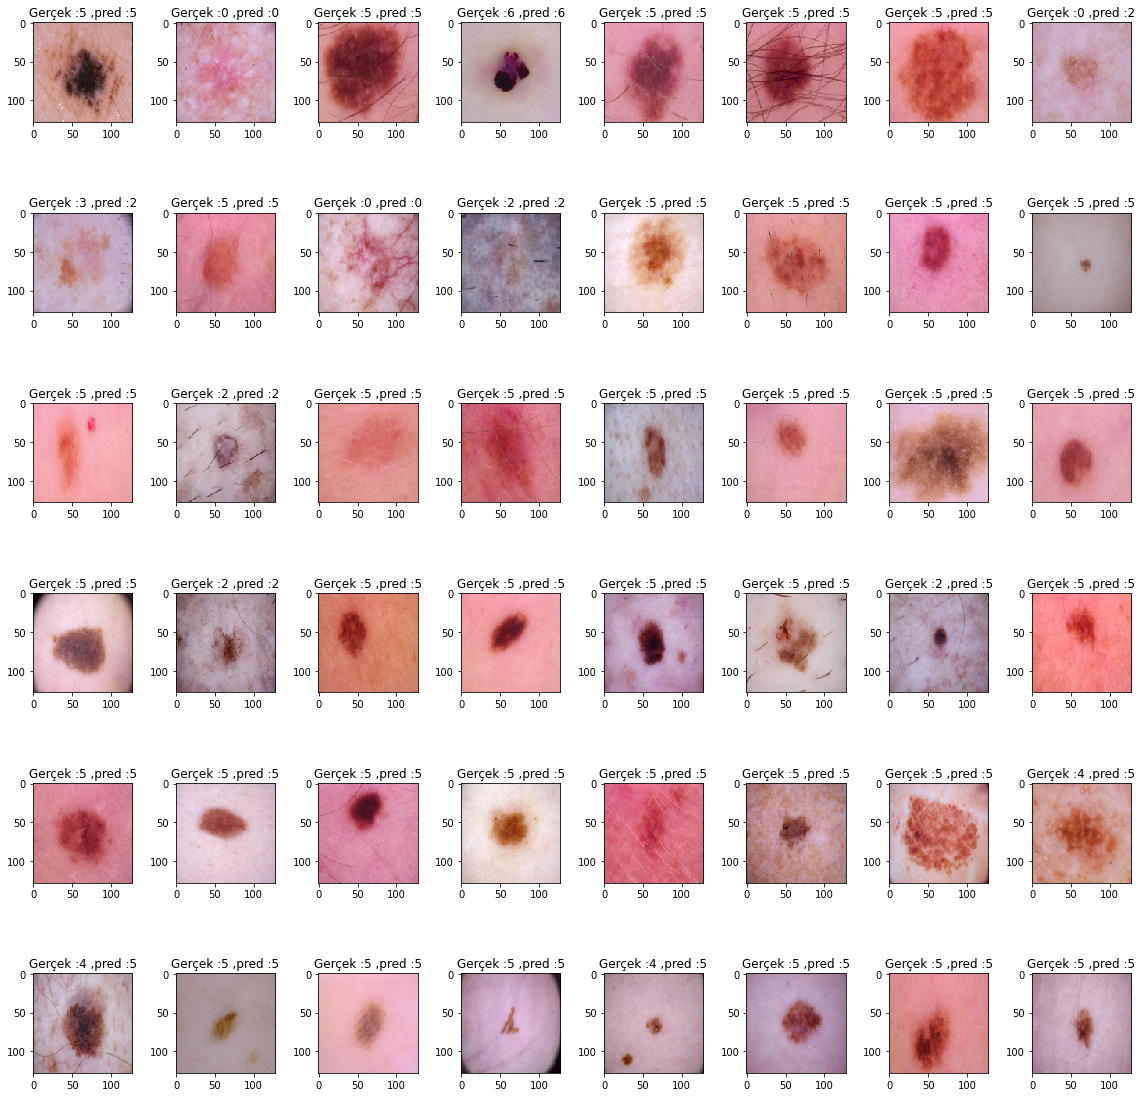

In [ ]:
y_pred  = model.predict(X_test).round()
correct = np.nonzero(y_pred == Y_test)[0]
plt.figure(figsize=(16,16))
k = 0
for c in correct[:48]:
            plt.subplot(6,8,k+1)
            plt.imshow(X_test[k].reshape(128,128,3) , interpolation='none')
            plt.title(f"Gerçek :{Y_test[k].argmax(axis = 0)} ,pred :{y_pred[k].argmax(axis = 0)}")
            k +=1 
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cancer_skin/sonuc/final_figure_v3.png',dpi=300)
plt.show()

            

[0. 0. 0. 0. 0. 1. 0.]


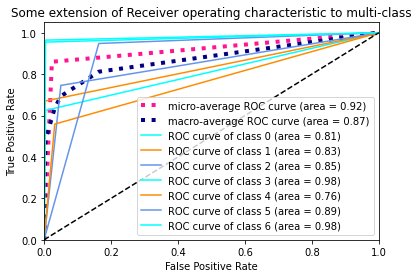



SINIFLANDIRMA RAPORU
---------------------
              precision    recall  f1-score   support

     0-akiec       0.82      0.62      0.71        64
       1-bcc       0.93      0.67      0.78       100
       2-bkl       0.66      0.75      0.70       228
        3-df       0.75      0.96      0.84        28
       4-mel       0.68      0.56      0.61       213
        5-nv       0.92      0.95      0.94      1348
      6-vasc       0.81      0.95      0.88        22

    accuracy                           0.86      2003
   macro avg       0.79      0.78      0.78      2003
weighted avg       0.86      0.86      0.86      2003



In [ ]:
from sklearn.metrics import roc_curve
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_test_cm = np.argmax(Y_test,axis=1)
#confusion_matrix(y_test_cm,y_pred)

# ROC GRAFİĞİ

fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_e = to_categorical(y_pred)

from sklearn.metrics import auc, roc_auc_score,roc_curve
from itertools import cycle

for i in range(len(Y_test[0])):
    fpr[i],tpr[i],_ = roc_curve(Y_test[:,i],y_pred_e[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

print(Y_test[0])

fpr["micro"],tpr["micro"],_ = roc_curve(Y_test.ravel(),y_pred_e.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(Y_test[0]))]))

mean_tpr = np.zeros_like(all_fpr)


for i in range(len(Y_test[0])):
    mean_tpr += np.interp(all_fpr,fpr[i],tpr[i])



mean_tpr /= len(Y_test[0])

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(Y_test[i])), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cancer_skin/sonuc/roc_v3.png',dpi=300)
plt.show()


labels = ['0-akiec', '1-bcc', '2-bkl', '3-df', '4-mel','5-nv', '6-vasc']
cr = "\n\nSINIFLANDIRMA RAPORU\n---------------------\n"
cr += classification_report(y_test_cm,y_pred, target_names=labels)
print(cr)

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/cancer_skin/InceptionV3.h5")
scores=model.evaluate(X_test,Y_test)
print("Test başarı oran:%{:.2f}".format(scores[1]*100))

scores=model.evaluate(X_val,Y_val)
print("Validation başarı oran:%{:.2f}".format(scores[1]*100))


63/63 [==============================] - 7s 16ms/step - loss: 0.5736 - acc: 0.8597
Test başarı oran:%85.97
26/26 [==============================] - 0s 16ms/step - loss: 0.7496 - acc: 0.8379
Validation başarı oran:%83.79
